This notebook tries to answare this:
 
**2. How are YouTube channels interconnected, and what does this connectivity indicate about their influence and reach?**

**This part is only for the gaming category**


**Network Analysis within Gaming Category:**

We plan to identify key influencers and collaboration patterns in the Gaming category. The objective is to construct a network graph representing channels as nodes and collaborations as edges.
Then we will determine centrality measures to identify influential channels and analyze the frequency and scope of collaborations. To identify influential nodes and sub-networks in the games category we can use graph-theoretic measures (Louvain Community Detection). Visualization can be done through the application of NetworkX.

Sources: 
- https://memgraph.com/blog/community-detection-algorithms-with-python-networkx
- https://towardsdatascience.com/community-detection-algorithms-9bd8951e7dae



In [30]:
#Import 
import gzip
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from itertools import product
import re
import seaborn as sns
import scipy.stats as stats
import os

# regression / matching
import statsmodels.formula.api as smf
import networkx as nx
from collections import defaultdict

In [2]:
#Define configuration-related variables 
DATA_path_collab_per_week = "C:\\Users\\Bruker\\ADA_project\\collaborators_per_week.csv"
DATA_path_collab_videos = "C:\\Users\\Bruker\\ADA_project\\dataframe_collaborations_videos.csv"

DEFAULT_ENCODING = 'UTF8'


In [3]:
# Read in data
def read_csv(file, chunk_size=30000): 
    file_path = os.path.join("C:\\Users\\Bruker\\ADA_project\\", file)
    chunk_list = []  # List to hold chunks
    for chunk in pd.read_csv(file_path, encoding=DEFAULT_ENCODING, chunksize=chunk_size):
        chunk_list.append(chunk)
    # Concatenate chunks into single DataFrame, if the csv had been close to the ram, it would be clever to put it in the loop. 
    df = pd.concat(chunk_list, ignore_index=True)
    return df

df_collab_videos = read_csv('dataframe_collaborations_videos.csv')
display(df_collab_videos)

,categories,channel_id,crawl_date,dislike_count,display_id,duration,like_count,upload_date,view_count,final_collaborator_ids
0,Gaming,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31 20:19:25.790269,0.0,y5IvyZlzELs,3442,9.0,2016-09-26,1253.0,NaN
1,Gaming,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31 20:19:28.334071,0.0,m1agc0qT0BY,2407,8.0,2016-09-25,2311.0,NaN
2,Gaming,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31 20:19:32.174979,1.0,rr6tfbBA9iY,1820,11.0,2016-09-24,5596.0,NaN
3,Gaming,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31 20:19:25.379061,0.0,ZGll5_wD9Ys,1209,8.0,2016-09-21,792.0,NaN
4,Gaming,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31 20:19:26.020550,426.0,kYkokQgnu20,2053,2076.0,2016-09-21,1141393.0,NaN
...,...,...,...,...,...,...,...,...,...,...
9166272,Gaming,UCrwIEEqUWswVQ_L_VzfeR-Q,2019-11-11 17:26:06.375078,12.0,s6mBrPKvumc,558,368.0,2018-09-26,10397.0,"['UCmiLzX1rvItY08BJmjwWZjQ', 'UChEkBnuYDNrP8tg..."
9166273,Gaming,UCrwIEEqUWswVQ_L_VzfeR-Q,2019-11-11 17:26:07.025547,16.0,qneHrPX4_AY,363,574.0,2018-09-25,13954.0,"['UCmiLzX1rvItY08BJmjwWZjQ', 'UChEkBnuYDNrP8tg..."
9166274,Gaming,UCrwIEEqUWswVQ_L_VzfeR-Q,2019-11-11 17:26:07.684503,32.0,4H4Oz0Rjd70,713,596.0,2018-09-24,24198.0,"['UCmiLzX1rvItY08BJmjwWZjQ', 'UChEkBnuYDNrP8tg..."
9166275,Gaming,UCrwIEEqUWswVQ_L_VzfeR-Q,2019-11-11 17:26:08.371065,65.0,c_34mr0tXDk,1306,1301.0,2018-09-23,93020.0,"['UCmiLzX1rvItY08BJmjwWZjQ', 'UChEkBnuYDNrP8tg..."


In [4]:
df_collab_per_week = read_csv('collaborators_per_week.csv')
display(df_collab_per_week)

,Year-Week,channel_id,collaborators_in_week
0,2016-00,UC-0Wg1wOUp-bRF1ZiC0dE8g,NaN
1,2016-00,UC-1pADhAUignVbTbVCW4Uuw,['UChm3iPolG6IVrIQ3bc6bIuQ' 'UCYFn32jjeY0Rx6jx...
2,2016-00,UC-3Oc4KY7pElZMbsWtm3X6A,NaN
3,2016-00,UC-3wJqf60YbC6jzAfPRm2ig,NaN
4,2016-00,UC-46hTnlyW3aCwjHs2acDzg,[None 'ARLNoble' 'xMattyG1' 'tiametmarduk1']
...,...,...,...
1872846,2019-42,UCoaHAPh8BecD4qjwmuE96aw,UC0p1OMeCD9OPNmIWCfqdJ7w
1872847,2019-43,UCoaHAPh8BecD4qjwmuE96aw,UC0p1OMeCD9OPNmIWCfqdJ7w
1872848,2019-44,UCRIxiOJN0Xd3evqxRu4iXew,['albertsunzheng' 'MrCasping']
1872849,2019-44,UCoaHAPh8BecD4qjwmuE96aw,UC0p1OMeCD9OPNmIWCfqdJ7w


In [5]:
#Make copys: 
df_collab_per_week.copy()
df_collab_videos.copy() 

,categories,channel_id,crawl_date,dislike_count,display_id,duration,like_count,upload_date,view_count,final_collaborator_ids
0,Gaming,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31 20:19:25.790269,0.0,y5IvyZlzELs,3442,9.0,2016-09-26,1253.0,NaN
1,Gaming,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31 20:19:28.334071,0.0,m1agc0qT0BY,2407,8.0,2016-09-25,2311.0,NaN
2,Gaming,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31 20:19:32.174979,1.0,rr6tfbBA9iY,1820,11.0,2016-09-24,5596.0,NaN
3,Gaming,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31 20:19:25.379061,0.0,ZGll5_wD9Ys,1209,8.0,2016-09-21,792.0,NaN
4,Gaming,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31 20:19:26.020550,426.0,kYkokQgnu20,2053,2076.0,2016-09-21,1141393.0,NaN
...,...,...,...,...,...,...,...,...,...,...
9166272,Gaming,UCrwIEEqUWswVQ_L_VzfeR-Q,2019-11-11 17:26:06.375078,12.0,s6mBrPKvumc,558,368.0,2018-09-26,10397.0,"['UCmiLzX1rvItY08BJmjwWZjQ', 'UChEkBnuYDNrP8tg..."
9166273,Gaming,UCrwIEEqUWswVQ_L_VzfeR-Q,2019-11-11 17:26:07.025547,16.0,qneHrPX4_AY,363,574.0,2018-09-25,13954.0,"['UCmiLzX1rvItY08BJmjwWZjQ', 'UChEkBnuYDNrP8tg..."
9166274,Gaming,UCrwIEEqUWswVQ_L_VzfeR-Q,2019-11-11 17:26:07.684503,32.0,4H4Oz0Rjd70,713,596.0,2018-09-24,24198.0,"['UCmiLzX1rvItY08BJmjwWZjQ', 'UChEkBnuYDNrP8tg..."
9166275,Gaming,UCrwIEEqUWswVQ_L_VzfeR-Q,2019-11-11 17:26:08.371065,65.0,c_34mr0tXDk,1306,1301.0,2018-09-23,93020.0,"['UCmiLzX1rvItY08BJmjwWZjQ', 'UChEkBnuYDNrP8tg..."


In [6]:
df_collab_videos_nonNAN = df_collab_videos.dropna(subset=['final_collaborator_ids'])
df_collab_videos_nonNAN.copy()
display(df_collab_videos_nonNAN)

df_collab_per_week_nonNAN = df_collab_per_week.dropna(subset=['collaborators_in_week'])
display(df_collab_per_week_nonNAN)



,categories,channel_id,crawl_date,dislike_count,display_id,duration,like_count,upload_date,view_count,final_collaborator_ids
926,Gaming,UCzWm1-4XF7AHxVUTkHCM1uw,2019-11-17 06:28:38.659449,22.0,glNTWlJ-DWo,878,114.0,2018-11-28,2570.0,['UC_0CVCfC_3iuHqmyClu59Uw']
966,Gaming,UCzWm1-4XF7AHxVUTkHCM1uw,2019-11-17 06:29:03.770975,36.0,YQx04vMXmcw,391,41.0,2017-05-27,1233.0,['UCCCmzJ3nCLEMYa3YbLmrKEw']
1039,Gaming,UCzWfqsjlvzAOUozsGFR3kbg,2019-10-31 15:41:29.005273,209.0,r75RJ9tCUXg,668,2581.0,2018-04-25,139470.0,['UC6ofrdxbm3RijOx6NsMU8Sg']
1108,Gaming,UCzWfqsjlvzAOUozsGFR3kbg,2019-10-31 15:41:10.122731,86.0,g2aaEEGHzQs,809,1529.0,2017-09-21,71869.0,['bentimm1']
1139,Gaming,UCzWfqsjlvzAOUozsGFR3kbg,2019-10-31 15:41:30.655084,36.0,d23UxeNKbWo,256,225.0,2017-08-22,9952.0,['UCNVnYNZQXjD2_HYsmO3F_rw']
...,...,...,...,...,...,...,...,...,...,...
9166272,Gaming,UCrwIEEqUWswVQ_L_VzfeR-Q,2019-11-11 17:26:06.375078,12.0,s6mBrPKvumc,558,368.0,2018-09-26,10397.0,"['UCmiLzX1rvItY08BJmjwWZjQ', 'UChEkBnuYDNrP8tg..."
9166273,Gaming,UCrwIEEqUWswVQ_L_VzfeR-Q,2019-11-11 17:26:07.025547,16.0,qneHrPX4_AY,363,574.0,2018-09-25,13954.0,"['UCmiLzX1rvItY08BJmjwWZjQ', 'UChEkBnuYDNrP8tg..."
9166274,Gaming,UCrwIEEqUWswVQ_L_VzfeR-Q,2019-11-11 17:26:07.684503,32.0,4H4Oz0Rjd70,713,596.0,2018-09-24,24198.0,"['UCmiLzX1rvItY08BJmjwWZjQ', 'UChEkBnuYDNrP8tg..."
9166275,Gaming,UCrwIEEqUWswVQ_L_VzfeR-Q,2019-11-11 17:26:08.371065,65.0,c_34mr0tXDk,1306,1301.0,2018-09-23,93020.0,"['UCmiLzX1rvItY08BJmjwWZjQ', 'UChEkBnuYDNrP8tg..."


,Year-Week,channel_id,collaborators_in_week
1,2016-00,UC-1pADhAUignVbTbVCW4Uuw,['UChm3iPolG6IVrIQ3bc6bIuQ' 'UCYFn32jjeY0Rx6jx...
4,2016-00,UC-46hTnlyW3aCwjHs2acDzg,[None 'ARLNoble' 'xMattyG1' 'tiametmarduk1']
7,2016-00,UC-AVK_NtJg6aSYAeEbYnfIw,theDarkElfX
8,2016-00,UC-BG8jc9gI_BpobNXldQuFw,['morachi24' 'BSquaredHD']
18,2016-00,UC-WA0qTCwuMCd418q_6xbEg,krypto9095
...,...,...,...
1872846,2019-42,UCoaHAPh8BecD4qjwmuE96aw,UC0p1OMeCD9OPNmIWCfqdJ7w
1872847,2019-43,UCoaHAPh8BecD4qjwmuE96aw,UC0p1OMeCD9OPNmIWCfqdJ7w
1872848,2019-44,UCRIxiOJN0Xd3evqxRu4iXew,['albertsunzheng' 'MrCasping']
1872849,2019-44,UCoaHAPh8BecD4qjwmuE96aw,UC0p1OMeCD9OPNmIWCfqdJ7w


In [7]:
print(type((df_collab_per_week['collaborators_in_week'].iloc[1])))
display(((df_collab_per_week['collaborators_in_week'].iloc[1])))
print(type((df_collab_per_week['collaborators_in_week'].iloc[0])))
display(((df_collab_per_week['collaborators_in_week'].iloc[0])))


<class 'str'>


"['UChm3iPolG6IVrIQ3bc6bIuQ' 'UCYFn32jjeY0Rx6jxd_b_QQA'\n 'UCj8pJC0ONCz5zClAewsbSOw']"

<class 'float'>


nan

In [8]:
unique_ids = set()
for row in df_collab_per_week['collaborators_in_week']:
    if pd.notna(row):
        # Remove characters that are not part of IDs and split the string
        cleaned_row = row.replace("[", "").replace("]", "").replace("'", "").replace("\n", " ")
        ids = cleaned_row.split()  # This splits the string on spaces
        for id in ids:
            unique_ids.add(id)

num_unique_ids = len(unique_ids)
print(f"Number of unique IDs: {num_unique_ids}")

Number of unique IDs: 191938


In [9]:
# Step 1: Data Cleaning and Transformation
def clean_and_extract_ids(row):
    # Implement the cleaning and extraction logic here
    # Return a list of channel IDs
    list_channel_ids = []
    try:
        cleaned_row = row.replace("[", "").replace("]", "").replace("'", "").replace("\n", " ").replace("None", "")
        ids = cleaned_row.split()  # This splits the string on spaces
        for id in ids:
            list_channel_ids.append(id)
    except Exception as e:
        print(f"Error processing row: {row}. Error: {e}")
    return list_channel_ids


# Apply the function to each row and create a new column for extracted IDs
df_collab_per_week_nonNAN['extracted_collaborators'] = df_collab_per_week_nonNAN['collaborators_in_week'].apply(clean_and_extract_ids)

display(df_collab_per_week_nonNAN)


C:\Users\Bruker\AppData\Local\Temp\ipykernel_9964\2311125195.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_collab_per_week_nonNAN['extracted_collaborators'] = df_collab_per_week_nonNAN['collaborators_in_week'].apply(clean_and_extract_ids)


,Year-Week,channel_id,collaborators_in_week,extracted_collaborators
1,2016-00,UC-1pADhAUignVbTbVCW4Uuw,['UChm3iPolG6IVrIQ3bc6bIuQ' 'UCYFn32jjeY0Rx6jx...,"[UChm3iPolG6IVrIQ3bc6bIuQ, UCYFn32jjeY0Rx6jxd_..."
4,2016-00,UC-46hTnlyW3aCwjHs2acDzg,[None 'ARLNoble' 'xMattyG1' 'tiametmarduk1'],"[ARLNoble, xMattyG1, tiametmarduk1]"
7,2016-00,UC-AVK_NtJg6aSYAeEbYnfIw,theDarkElfX,[theDarkElfX]
8,2016-00,UC-BG8jc9gI_BpobNXldQuFw,['morachi24' 'BSquaredHD'],"[morachi24, BSquaredHD]"
18,2016-00,UC-WA0qTCwuMCd418q_6xbEg,krypto9095,[krypto9095]
...,...,...,...,...
1872846,2019-42,UCoaHAPh8BecD4qjwmuE96aw,UC0p1OMeCD9OPNmIWCfqdJ7w,[UC0p1OMeCD9OPNmIWCfqdJ7w]
1872847,2019-43,UCoaHAPh8BecD4qjwmuE96aw,UC0p1OMeCD9OPNmIWCfqdJ7w,[UC0p1OMeCD9OPNmIWCfqdJ7w]
1872848,2019-44,UCRIxiOJN0Xd3evqxRu4iXew,['albertsunzheng' 'MrCasping'],"[albertsunzheng, MrCasping]"
1872849,2019-44,UCoaHAPh8BecD4qjwmuE96aw,UC0p1OMeCD9OPNmIWCfqdJ7w,[UC0p1OMeCD9OPNmIWCfqdJ7w]


In [15]:
# Function to create edges from a row
def create_edges(row):
    return list(product([row['channel_id']], row['extracted_collaborators']))

chunk_size = 50000
edges = []

for start in range(0, len(df_collab_per_week_nonNAN), chunk_size):
    chunk = df_collab_per_week_nonNAN.iloc[start:start + chunk_size]
    chunk_edges = chunk.apply(create_edges, axis=1).explode().tolist()
    edges.extend(chunk_edges)

print(edges[:10])

[('UC-1pADhAUignVbTbVCW4Uuw', 'UChm3iPolG6IVrIQ3bc6bIuQ'), ('UC-1pADhAUignVbTbVCW4Uuw', 'UCYFn32jjeY0Rx6jxd_b_QQA'), ('UC-1pADhAUignVbTbVCW4Uuw', 'UCj8pJC0ONCz5zClAewsbSOw'), ('UC-46hTnlyW3aCwjHs2acDzg', 'ARLNoble'), ('UC-46hTnlyW3aCwjHs2acDzg', 'xMattyG1'), ('UC-46hTnlyW3aCwjHs2acDzg', 'tiametmarduk1'), ('UC-AVK_NtJg6aSYAeEbYnfIw', 'theDarkElfX'), ('UC-BG8jc9gI_BpobNXldQuFw', 'morachi24'), ('UC-BG8jc9gI_BpobNXldQuFw', 'BSquaredHD'), ('UC-WA0qTCwuMCd418q_6xbEg', 'krypto9095')]


Number of nodes: 201936
Number of edges: 297276


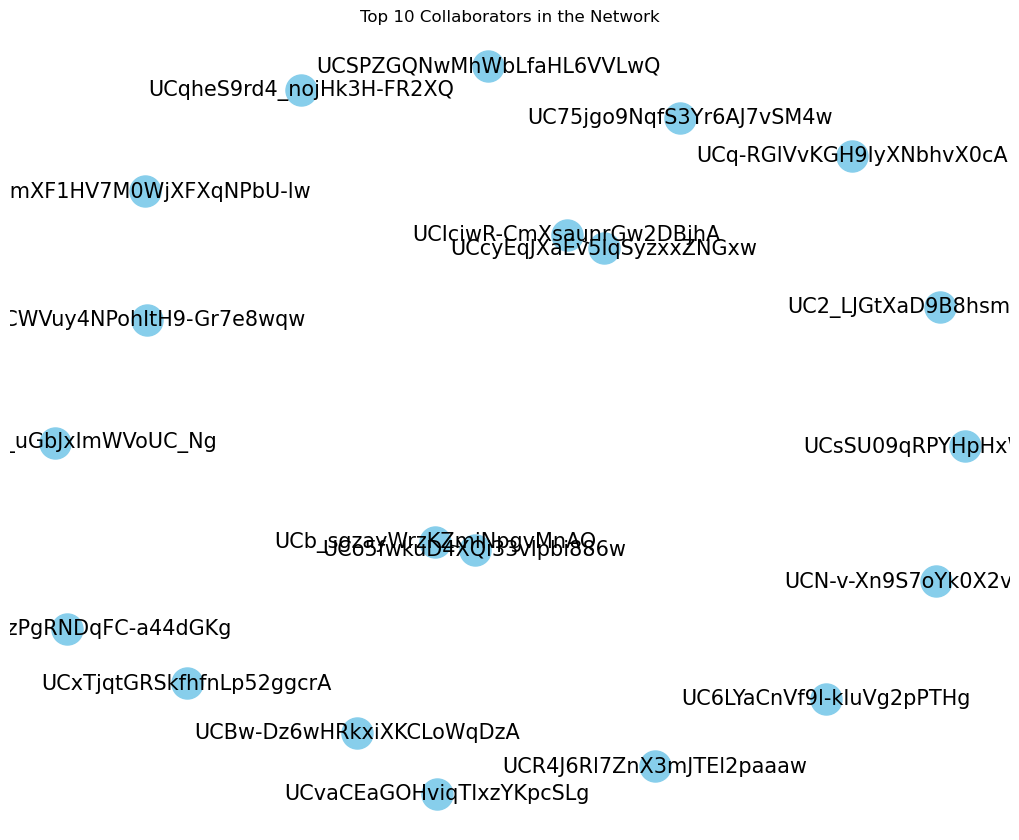

Channel UCBw-Dz6wHRkxiXKCLoWqDzA has 11422 collaborations
Channel UCIciwR-CmXsaunrGw2DBjhA has 3351 collaborations
Channel UCxTjqtGRSkfhfnLp52ggcrA has 2838 collaborations
Channel UCN-v-Xn9S7oYk0X2v1jx1Qg has 1779 collaborations
Channel UCWVuy4NPohItH9-Gr7e8wqw has 1702 collaborations
Channel UCvaCEaGOHviqTIxzYKpcSLg has 1676 collaborations
Channel UC6LYaCnVf9l-kIuVg2pPTHg has 1592 collaborations
Channel UCo5fwkuD4XQi33vIpbi886w has 1525 collaborations
Channel UC2_LJGtXaD9B8hsmXLj4IRw has 1237 collaborations
Channel UCv5gQgP_uGbJxImWVoUC_Ng has 1145 collaborations
Channel UCmXF1HV7M0WjXFXqNPbU-lw has 1074 collaborations
Channel UCROCRCzPgRNDqFC-a44dGKg has 1032 collaborations
Channel UCb_sgzayWrzKZmiNpgvMnAQ has 1020 collaborations
Channel UCqheS9rd4_nojHk3H-FR2XQ has 1000 collaborations
Channel UCR4J6Rl7ZnX3mJTEl2paaaw has 998 collaborations
Channel UC75jgo9NqfS3Yr6AJ7vSM4w has 976 collaborations
Channel UCcyEqJXaEv5IqSyzxxZNGxw has 914 collaborations
Channel UCSPZGQNwMhWbLfaHL6VVLwQ 

In [28]:
# Assuming 'edges' is your complete list of edges
first_1000_edges = edges[:]  # Take the first 1000 edges

# Create the network graph
G = nx.Graph()
G.add_edges_from(first_1000_edges)

# Basic network analysis
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

# Assuming G is your graph
degree_dict = dict(G.degree())  # Returns a dict where keys are nodes and values are their degree
top_10_nodes = sorted(degree_dict, key=degree_dict.get, reverse=True)[:20]  # Top 10 nodes

# Create a subgraph with only these top 10 nodes
H = G.subgraph(top_10_nodes)

# Visualization
plt.figure(figsize=(10, 8))
nx.draw(H, with_labels=True, node_color='skyblue', node_size=500, font_size=15)
plt.title("Top 10 Collaborators in the Network")
plt.show()

for node in top_10_nodes:
    print(f"Channel {node} has {degree_dict[node]} collaborations")

**The problem** it does not show how is collaborating with how? It does not give a picture of how they are connected... How can i make connections? Could i look at the top 20 - collaborators, and then make connection between them, and if they id is not in top 20, then it is connected to the outside (say a big box called outside)

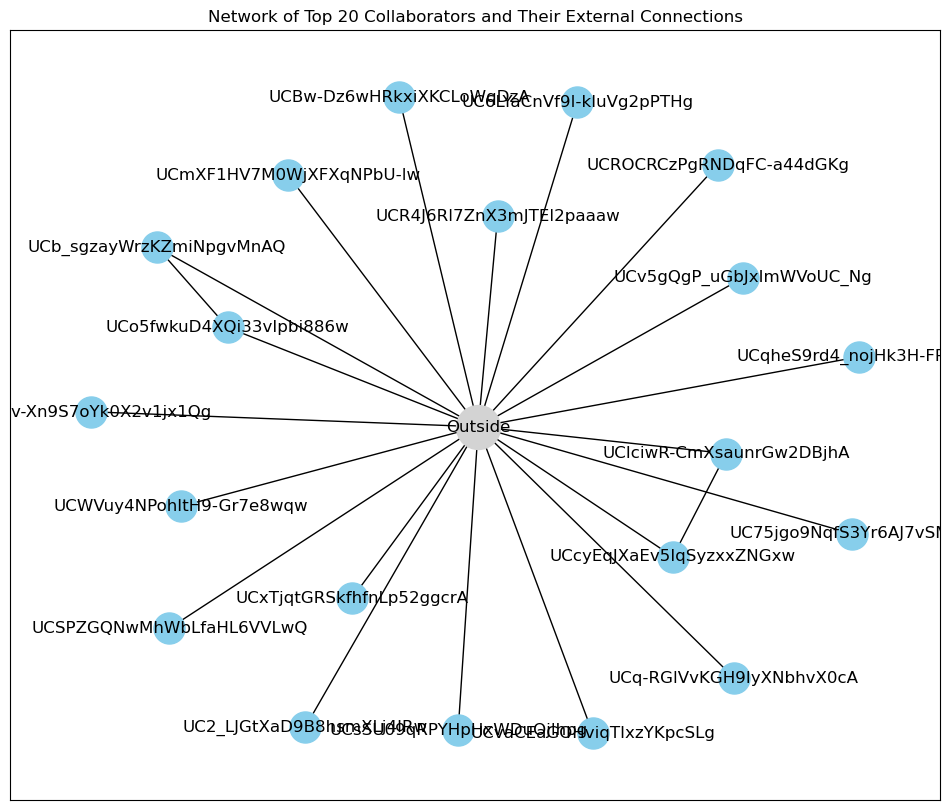

In [29]:
# Get the top 20 collaborators
degree_dict = dict(G.degree())
top_20_nodes = sorted(degree_dict, key=degree_dict.get, reverse=True)[:20]

# Create a modified graph
H = nx.Graph()
outside_node = "Outside"
for edge in edges:
    if edge[0] in top_20_nodes:
        if edge[1] in top_20_nodes:
            # Both nodes are in the top 20
            H.add_edge(edge[0], edge[1])
        else:
            # The second node is "outside"
            H.add_edge(edge[0], outside_node)
    elif edge[1] in top_20_nodes:
        # The first node is "outside"
        H.add_edge(outside_node, edge[1])

# Visualization
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(H)  # Layout for the graph
nx.draw_networkx_nodes(H, pos, nodelist=top_20_nodes, node_color='skyblue', node_size=500)
nx.draw_networkx_nodes(H, pos, nodelist=[outside_node], node_color='lightgrey', node_size=1000)
nx.draw_networkx_edges(H, pos)
nx.draw_networkx_labels(H, pos)
plt.title("Network of Top 20 Collaborators and Their External Connections")
plt.show()

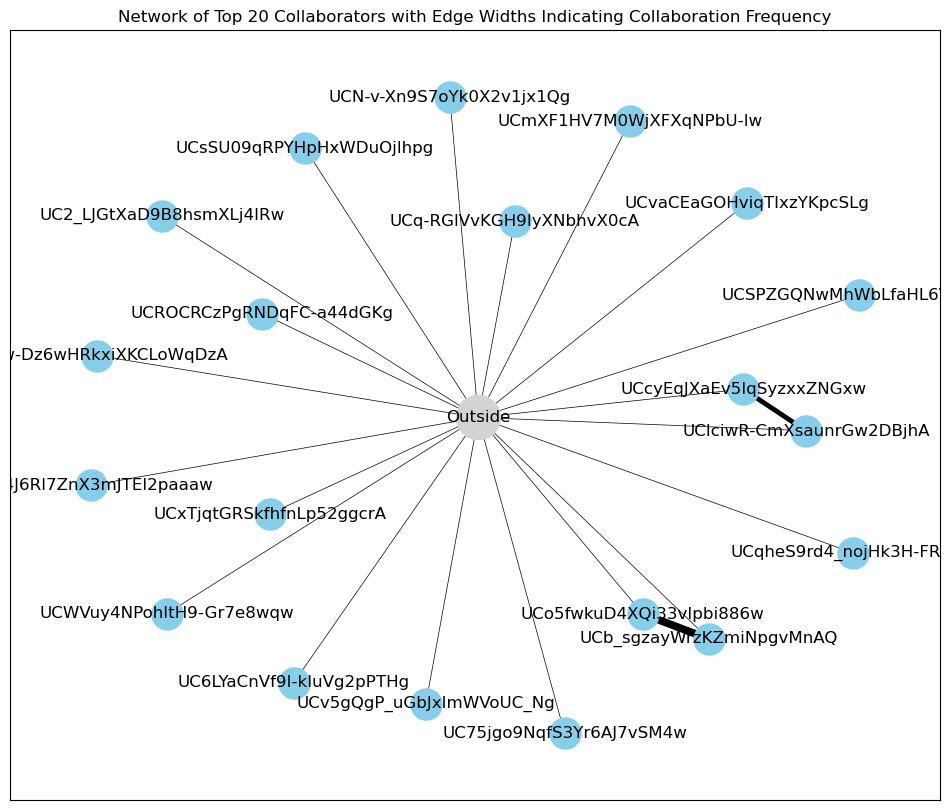

In [33]:
# Count the collaborations
collaboration_count = defaultdict(int)
for edge in edges:
    # Count collaborations for both (node1, node2) and (node2, node1) as the same
    if (edge[1], edge[0]) in collaboration_count:
        collaboration_count[(edge[1], edge[0])] += 1
    else:
        collaboration_count[edge] += 1

# Get the top 20 collaborators
degree_dict = dict(G.degree())
top_20_nodes = sorted(degree_dict, key=degree_dict.get, reverse=True)[:20]

# Create a modified graph with weighted edges
H = nx.Graph()
outside_node = "Outside"
for edge, weight in collaboration_count.items():
    if edge[0] in top_20_nodes or edge[1] in top_20_nodes:
        # At least one node is in the top 20
        if edge[0] not in top_20_nodes:
            edge = (outside_node, edge[1])
        elif edge[1] not in top_20_nodes:
            edge = (edge[0], outside_node)
        H.add_edge(*edge, weight=weight)

# Visualization
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(H)  # Layout for the graph

# Draw nodes
nx.draw_networkx_nodes(H, pos, nodelist=top_20_nodes, node_color='skyblue', node_size=500)
nx.draw_networkx_nodes(H, pos, nodelist=[outside_node], node_color='lightgrey', node_size=1000)


# Draw edges with widths based on weight
edge_widths = [H[u][v]['weight'] / 2 for u, v in H.edges()]  # Scale for visualization
nx.draw_networkx_edges(H, pos, width=edge_widths)

# Draw labels
nx.draw_networkx_labels(H, pos)

plt.title("Network of Top 20 Collaborators with Edge Widths Indicating Collaboration Frequency")
plt.show()

**Comment** what we see is that 

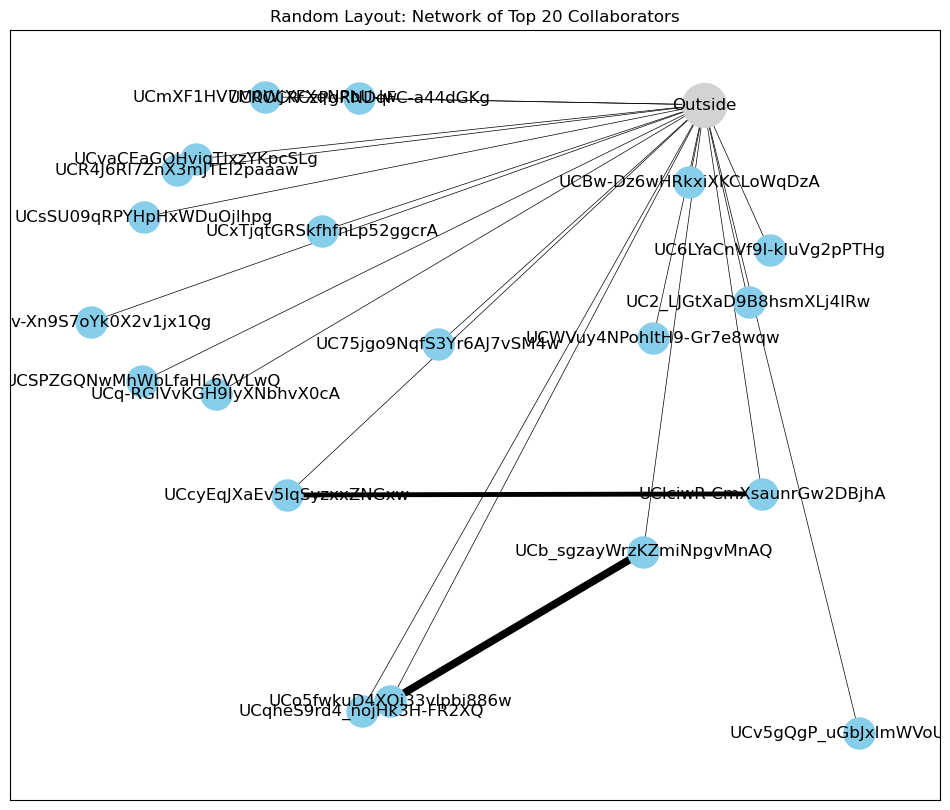

In [36]:
plt.figure(figsize=(12, 10))
pos_random = nx.random_layout(H)  # Random layout
nx.draw_networkx_nodes(H, pos_random, nodelist=top_20_nodes, node_color='skyblue', node_size=500)
nx.draw_networkx_nodes(H, pos_random, nodelist=[outside_node], node_color='lightgrey', node_size=1000)
nx.draw_networkx_edges(H, pos_random, width=edge_widths)
nx.draw_networkx_labels(H, pos_random)
plt.title("Random Layout: Network of Top 20 Collaborators")
plt.show()


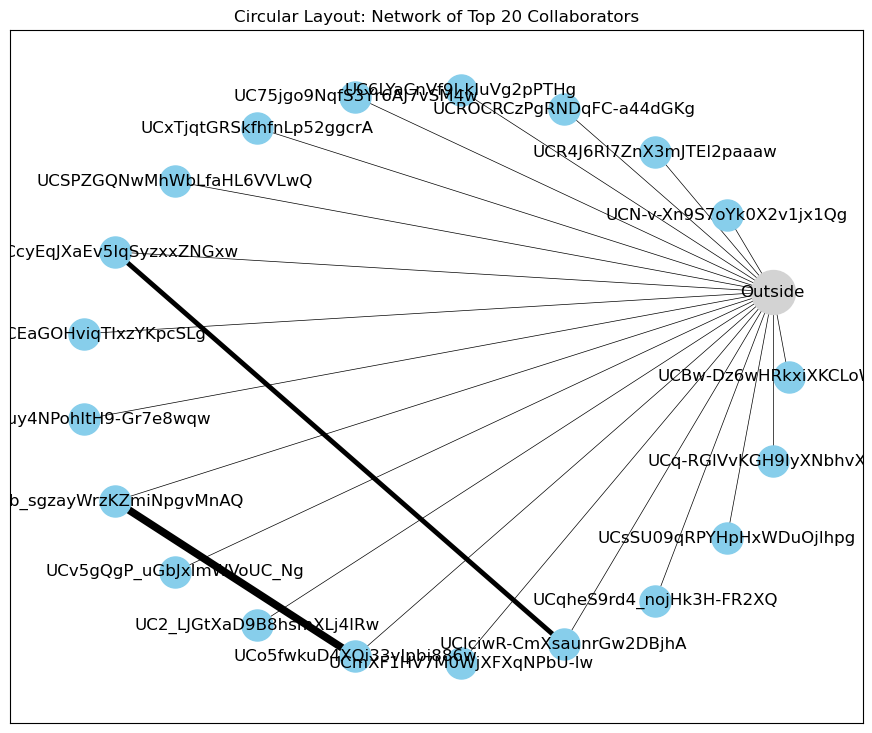

In [38]:
plt.figure(figsize=(11, 9))
pos_circular = nx.circular_layout(H)  # Circular layout
nx.draw_networkx_nodes(H, pos_circular, nodelist=top_20_nodes, node_color='skyblue', node_size=500)
nx.draw_networkx_nodes(H, pos_circular, nodelist=[outside_node], node_color='lightgrey', node_size=1000)
nx.draw_networkx_edges(H, pos_circular, width=edge_widths)
nx.draw_networkx_labels(H, pos_circular)
plt.title("Circular Layout: Network of Top 20 Collaborators")
plt.show()

What could be cool is to rank after popularity, and then find collaborations. This graph is only between other channels that collaborate a lot. 

Another aspect is two find the network centrality and the different measurements, that we talked about in the method section. 

Need to make some good visualizations. 

There was no problem running the graph on the whole dataset, but i had done some problems when working with the dataframe. 

**Task next time**
1) Start with the different metrics we talked about in the methode. 
2) Try to filter on popularity, and then find the amount of collaborations in the top 20 vs the rest. 
3) Think about the datastory
4) Use excersice on networks to get inspiration